# 初期設定

In [1]:
import sklearn.metrics.pairwise
from importlib import reload

In [2]:
#上書きするメソッド

#コサイン類似度
def cos_sim(X, Y):
    return np.dot(X, Y)/(np.linalg.norm(X)*np.linalg.norm(Y))
    
#コサイン類似度の非類似度化
def cos_sim_distances(X, Y):
    return 1-cos_sim(X, Y)

def sub_cos_sim_distances(X, row_index_1, row_index_2):
    cossim_distance = cos_sim_distances(X[row_index_1], X[row_index_2])
    return (cossim_distance, row_index_1, row_index_2)

def middle_cos_sim_distances(X, Y=None):
    if Y is None:
        #Xだけが入力されていて、Xが2d-arrayの場合
        row_combinations = list(combinations(range(0, len(X)), 2))
        cos_sim_set = [sub_cos_sim_distances(X, index_set_tuple[0], index_set_tuple[1]) for index_set_tuple in row_combinations]
        return np.array(cos_sim_set)
    
    #不明なため一旦中断
    
    elif len(X.shape)==1 and len(Y.shape)==2:
        cos_sim_set = np.array([cos_sim_distances(X, Y[y_sample_index]) for y_sample_index in range(0, Y.shape[0])])
        return np.array(cos_sim_set)
    
    elif  len(X.shape)==2 and len(Y.shape)==2:
        cos_sim_x_and_all_y = lambda XX, YY: np.array([cos_sim_distances(XX, YY[y_sample_index]) for y_sample_index in range(0, YY.shape[0])])
        cos_sim_divergence_set = np.array([cos_sim_x_and_all_y(X[x_i], Y) for x_i in range(0, X.shape[0])])
        return np.array(cos_sim_divergence_set)
    
    else:
        raise Exception("Exception case caused")

def middle_cos_sim_distances(X, Y=None):
    X = np.array(X)
    Y = np.array(Y)
    if len(Y.shape) == 0:
        #Xだけが入力されていて、Xが2d-arrayの場合
        row_combinations = list(combinations(range(0, len(X)), 2))
        cos_sim_set = [sub_cos_sim_distances(X, index_set_tuple[0], index_set_tuple[1]) for index_set_tuple in row_combinations]

        data = [t[0] for t in cos_sim_set]
        row = [t[1] for t in cos_sim_set]
        col = [t[2] for t in cos_sim_set]

        distance_matrix = np.zeros((len(X), len(X)))
        distance_matrix[row, col] = data
        return distance_matrix+distance_matrix.T
    
    elif len(X.shape) == 1 and len(Y.shape) == 2:
        cos_sim_set = np.array([cos_sim_distances(X, Y[y_sample_index]) for y_sample_index in range(0, Y.shape[0])])
        return np.array(cos_sim_set)
    
    elif  len(X.shape) == 2 and len(Y.shape) == 2:
        cos_sim_x_and_all_y = lambda XX, YY: np.array([cos_sim_distances(XX, YY[y_sample_index]) for y_sample_index in range(0, YY.shape[0])])
        cos_sim_divergence_set = np.array([cos_sim_x_and_all_y(X[x_i], Y) for x_i in range(0, X.shape[0])])
        return np.array(cos_sim_divergence_set)
    
    else:
        raise Exception("Exception case caused")
        
#k_meansの距離に定義を合わせる
def new_cos_sim_distances(X, Y=None, Y_norm_squared=None, squared=False, X_norm_squared=None):
    return middle_cos_sim_distances(X, Y)

In [3]:
sklearn.metrics.pairwise.euclidean_distances = new_cos_sim_distances

In [4]:
#他に必要なパッケージをimport
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

from sklearn.cluster import KMeans

# 乱数の発生

In [5]:
#乱数の生成
np.random.seed(0)
x1 = np.array([np.random.normal(loc, 1, 20) for loc in [2, 10, -2]]).flatten() #ランダムな80個の数を生成
x2 = np.array([np.random.normal(loc, 1, 20) for loc in [0, 10, 0]]).flatten() #ランダムな80個の数を生成

#入力データ
X = np.c_[x1, x2]

No handles with labels found to put in legend.
findfont: Font family ['Hiragino Kaku Gothic Pro'] not found. Falling back to DejaVu Sans.


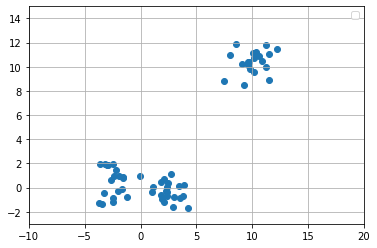

In [6]:
#散布図で表示
plt.rcParams["font.family"] = "Hiragino Kaku Gothic Pro"
plt.scatter(x1, x2)
plt.xlim(-10, 20)
plt.ylim(-3, 15)
plt.legend()
plt.grid()
plt.show()

## コサイン類似度でk-meansを実行

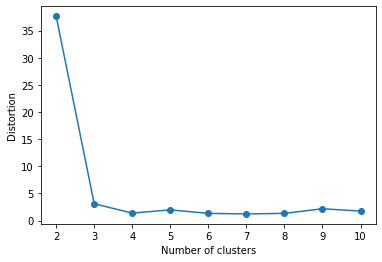

In [7]:
#エルボー法を用いてクラスタ数を決定する
distortions_cos_sim = []

for i  in range(2,11):                # 1~10クラスタまで一気に計算 
    km_model_cos_sim = KMeans(    
        n_clusters=i,
        init='k-means++',     # k-means++法によりクラスタ中心を選択
        n_init=10,
        max_iter=300,
        random_state=0)
    y_km_cos_sim = km_model_cos_sim.fit(X)  # クラスタリングの計算を実行
    
    #郡内分散を計算してそれをエルボー法で実装
    result_cos_sim = np.c_[X, y_km_cos_sim.labels_]
    distortions_cos_sim.append(sum([sum([cos_sim_distances(col, y_km_cos_sim.cluster_centers_[j]) for col in result_cos_sim[result_cos_sim[:,2] == j][:, 0:2]]) for j in set(y_km_cos_sim.labels_)]))

plt.plot(range(2,11),distortions_cos_sim,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

No handles with labels found to put in legend.
findfont: Font family ['Hiragino Kaku Gothic Pro'] not found. Falling back to DejaVu Sans.


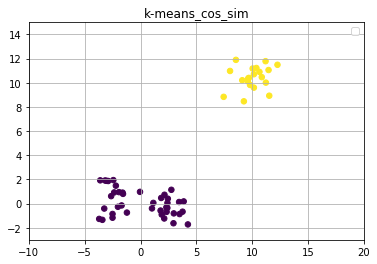

In [8]:
#kmeansを実装
km_model_cos_sim = KMeans(
    n_clusters = 2,
    random_state = 10,
    init = "random"
    )

#モデルへのあてはめ
y_km_cos_sim = km_model_cos_sim.fit(X)

#結果をプロット
plt.rcParams["font.family"] = "Hiragino Kaku Gothic Pro"
plt.scatter(x1, x2, c = y_km_cos_sim.labels_, s = 30)
plt.xlim(-10, 20)
plt.ylim(-3, 15)
plt.title("k-means_cos_sim")
plt.legend()
plt.grid()
plt.show()

In [9]:
y_km_cos_sim.cluster_centers_

array([[ 0.08712577,  0.07222969],
       [10.05575035, 10.42120921]])

# テスト

In [9]:
 sklearn.cluster._kmeans.euclidean_distances

<function __main__.new_cos_sim_distances(X, Y=None, Y_norm_squared=None, squared=False, X_norm_squared=None)>

In [68]:
A = [[1,0]]
B = [[1,0],[0,1]]

In [51]:
euclidean_distances(A，B)

SyntaxError: invalid character in identifier (<ipython-input-51-0a42c85e3203>, line 1)

In [69]:
new_cos_sim_distances(A,B)

array([[0., 1.]])

In [19]:
A = np.array(A)

In [36]:
B = None
B = np.array(B)

In [61]:
_,n_features = X.shape

In [62]:
centers = np.empty((2, n_features), dtype=X.dtype)

In [70]:
stable_cumsum(closest_dist_sq)


NameError: name 'stable_cumsum' is not defined

In [94]:
classX = np.c_[X, np.random.randint(0,3, X.shape[0])]
center = np.empty((3,2))

In [97]:
center[0]= [classX[classX[:, 2]==0][:,0:2][0].mean(),classX[classX[:, 2]==0][:,0:2][1].mean()]
center[1]= [classX[classX[:, 2]==1][:,0:2][0].mean(),classX[classX[:, 2]==1][:,0:2][1].mean()]
center[2]= [classX[classX[:, 2]==2][:,0:2][0].mean(),classX[classX[:, 2]==2][:,0:2][1].mean()]

In [98]:
center

array([[1.54579595, 0.31047059],
       [1.02030202, 1.08279585],
       [2.02249207, 1.43656707]])

In [101]:
t0 = new_cos_sim_distances(center[0], X)
t1 = new_cos_sim_distances(center[1], X)
t2 = new_cos_sim_distances(center[2], X)

In [102]:
dis = np.c_[t0, t1, t2]

In [107]:
dis[0]

array([0.06949215, 0.45289352, 0.29928031])

In [109]:
class_num = [list(d).index(min(d)) for d in dis]

In [110]:
classX = np.c_[X, class_num]

In [111]:
classX

array([[ 3.76405235, -0.67246045,  0.        ],
       [ 2.40015721, -0.35955316,  0.        ],
       [ 2.97873798, -0.81314628,  0.        ],
       [ 4.2408932 , -1.7262826 ,  0.        ],
       [ 3.86755799,  0.17742614,  0.        ],
       [ 1.02272212, -0.40178094,  0.        ],
       [ 2.95008842, -1.63019835,  0.        ],
       [ 1.84864279,  0.46278226,  0.        ],
       [ 1.89678115, -0.90729836,  0.        ],
       [ 2.4105985 ,  0.0519454 ,  0.        ],
       [ 2.14404357,  0.72909056,  0.        ],
       [ 3.45427351,  0.12898291,  0.        ],
       [ 2.76103773,  1.13940068,  0.        ],
       [ 2.12167502, -1.23482582,  0.        ],
       [ 2.44386323,  0.40234164,  0.        ],
       [ 2.33367433, -0.68481009,  0.        ],
       [ 3.49407907, -0.87079715,  0.        ],
       [ 1.79484174, -0.57884966,  0.        ],
       [ 2.3130677 , -0.31155253,  0.        ],
       [ 1.14590426,  0.05616534,  0.        ],
       [ 7.44701018,  8.83485016,  1.   

In [123]:
classX = np.c_[X, np.random.randint(0,3, X.shape[0])]
center_before = np.empty((2,2))
center_after = np.empty((2,2))

sabun = 1

#繰り返し
while(sabun > 0.1):
    center_before[0]= [classX[classX[:, 2]==0][:,0:2][0].mean(),classX[classX[:, 2]==0][:,0:2][1].mean()]
    center_before[1]= [classX[classX[:, 2]==1][:,0:2][0].mean(),classX[classX[:, 2]==1][:,0:2][1].mean()]
    #center_before[2]= [classX[classX[:, 2]==2][:,0:2][0].mean(),classX[classX[:, 2]==2][:,0:2][1].mean()]

    t0 = new_cos_sim_distances(center[0], X)
    t1 = new_cos_sim_distances(center[1], X)
    #t2 = new_cos_sim_distances(center[2], X)

    dis = np.c_[t0, t1]

    class_num = [list(d).index(min(d)) for d in dis]

    classX = np.c_[X, class_num]

    center_after[0]= [classX[classX[:, 2]==0][:,0:2][0].mean(),classX[classX[:, 2]==0][:,0:2][1].mean()]
    center_after[1]= [classX[classX[:, 2]==1][:,0:2][0].mean(),classX[classX[:, 2]==1][:,0:2][1].mean()]
    #center_after[2]= [classX[classX[:, 2]==2][:,0:2][0].mean(),classX[classX[:, 2]==2][:,0:2][1].mean()]

    sabun = sum(sum((center_before-center_after)**2))

No handles with labels found to put in legend.


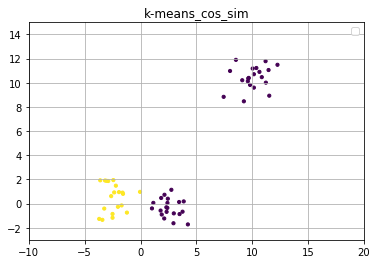

In [128]:
plt.rcParams["font.family"] = "Hiragino Kaku Gothic Pro"
plt.scatter(x1, x2, c = class_num, s = 10)
plt.xlim(-10, 20)
plt.ylim(-3, 15)
plt.title("k-means_cos_sim")
plt.legend()
plt.grid()
plt.show()